# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

# Our functions

In [2]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores
from PPO import ppo_update, RolloutBuffer, evaluate_policy

# Training loop for OPPO
from OPPO import baseline_CartPole_V0, baseline_MountainCar, OPPO_update
from OPPO import baseline_1, baseline_CartPole_v0_Fla
from PPO_Fla import *

## Parameters

## CartPole v0

c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Training:   0%|          | 0/1200 [00:00<?, ?episode/s]

Episode 20 	 Average Score over the last 20 episodes: 22.1
Episode 40 	 Average Score over the last 20 episodes: 23.6
Episode 60 	 Average Score over the last 20 episodes: 22.9
Episode 80 	 Average Score over the last 20 episodes: 30.3
Episode 100 	 Average Score over the last 20 episodes: 34.8
Episode 120 	 Average Score over the last 20 episodes: 51.9
Episode 140 	 Average Score over the last 20 episodes: 53.0
Episode 160 	 Average Score over the last 20 episodes: 50.9
Episode 180 	 Average Score over the last 20 episodes: 81.0
Environment reached the half target score in 188 episodes! Average Score: 90.70
Saving the policy in pi2_oppo_CartPole-v0_seed_42.pth...
Episode 200 	 Average Score over the last 20 episodes: 91.2
Episode 220 	 Average Score over the last 20 episodes: 130.9
Episode 240 	 Average Score over the last 20 episodes: 163.1
Episode 260 	 Average Score over the last 20 episodes: 132.1
Episode 280 	 Average Score over the last 20 episodes: 140.8
Episode 300 	 Average S

c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Evaluations over 100 episodes done for both policies


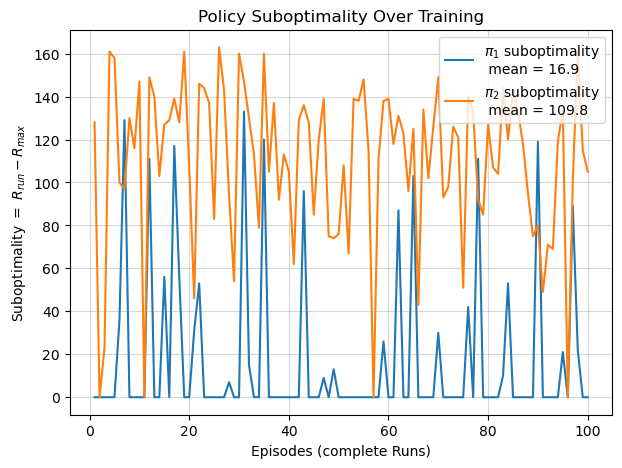

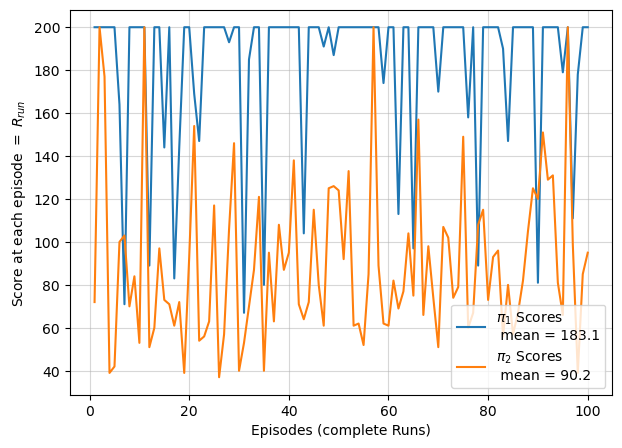

In [3]:
# Choose environment:

# env 1: CartPole-v0
env_name='CartPole-v0'
baseline = baseline_CartPole_v0_Fla
target_score = 180 # for CartPole-v0

# env 2: Continuous-MountainCar-v0
# env_name='MountainCar-v0'
# baseline = baseline_MountainCar
# target_score = -110 # for Continuous-MountainCar-v0

lr_oppo = 0.003 # learning rate for OPPO

load_policies = False

# ── Hyperparams for OPPO ──
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 200  # cap on steps per episode
print_every             = 20   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99

seed_training_policies  = 42


# ── Instantiate the two policies & optimizers for OPPO ──
env_oppo   = gym.make(env_name)

pi1_oppo = Policy_v3(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = Policy_v3(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))


# ── Run the OPPO training ──
if not load_policies:
  # Training the policy:
  scores_oppo = OPPO_update(
      policy       = pi1_oppo,
      optimizer    = opt1_oppo,
      env          = env_oppo,
      baseline     = baseline,
      n_episodes   = n_episodes,
      max_t        = max_t,
      gamma        = gamma,      # you can reuse your PPO γ
      print_every  = print_every,
      early_stop   = False,
      seed = seed_training_policies,
      target_score = target_score,
      env_name= env_name,
      display_every = False
  )

pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


seed_evaluation = 26
num_episodes = 100

pi1_reward = evaluate_policy_fla(env_name, pi1_oppo, n_episodes=num_episodes)
pi2_reward = evaluate_policy_fla(env_name, pi2_oppo, n_episodes=num_episodes)
print("Evaluations over", num_episodes, "episodes done for both policies")

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    max_reward=200, # for CartPole-v0
)

plot_Scores(
    pi1_reward,
    pi2_reward,
)


## CartPole v1

  0%|          | 0/1200 [00:00<?, ?it/s]

Episode 20 	 Average Score over the last 20 episodes: 21.9
Episode 40 	 Average Score over the last 20 episodes: 32.2
Episode 60 	 Average Score over the last 20 episodes: 35.8
Episode 80 	 Average Score over the last 20 episodes: 47.6
Episode 100 	 Average Score over the last 20 episodes: 45.4
Episode 120 	 Average Score over the last 20 episodes: 59.6
Episode 140 	 Average Score over the last 20 episodes: 68.8
Episode 160 	 Average Score over the last 20 episodes: 61.5
Episode 180 	 Average Score over the last 20 episodes: 65.0
Episode 200 	 Average Score over the last 20 episodes: 57.2
Episode 220 	 Average Score over the last 20 episodes: 91.8
Episode 240 	 Average Score over the last 20 episodes: 82.7
Episode 260 	 Average Score over the last 20 episodes: 101.0
Episode 280 	 Average Score over the last 20 episodes: 181.2
Environment reached the half target score in 290 episodes! Average Score: 227.00
Saving the policy in pi2_oppo_CartPole-v1.pth...
Episode 300 	 Average Score over

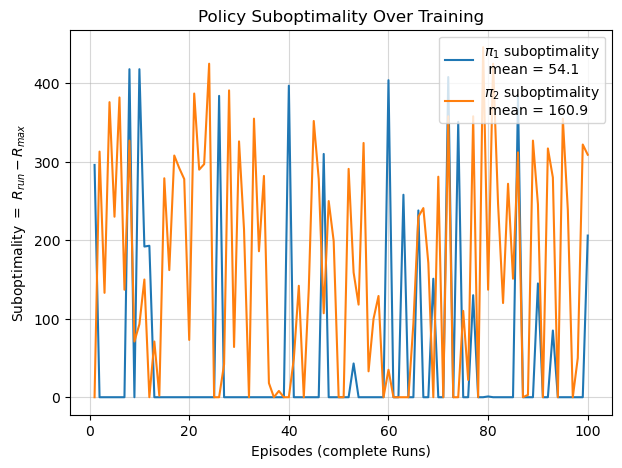

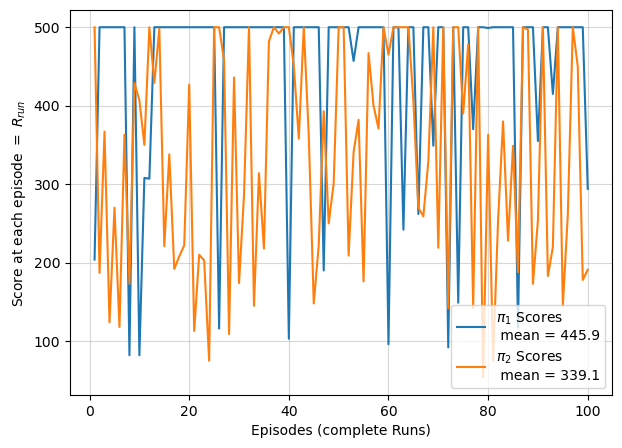

In [16]:
# Choose environment:

# env 1: CartPole-v0
env_name='CartPole-v1'
baseline = baseline_CartPole_v0_Fla
target_score = 450 # for CartPole-v0

# env 2: Continuous-MountainCar-v0
# env_name='MountainCar-v0'
# baseline = baseline_MountainCar
# target_score = -110 # for Continuous-MountainCar-v0

lr_oppo = 0.005 # learning rate for OPPO

load_policies = False

# ── Hyperparams for OPPO ──
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 500  # cap on steps per episode
print_every             = 20   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99

seed_training_policies  = 42


# ── Instantiate the two policies & optimizers for OPPO ──
env_oppo   = gym.make(env_name)

pi1_oppo = Policy_v3(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = Policy_v3(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))


# ── Run the OPPO training ──
if not load_policies:
  # Training the policy:
  scores_oppo = OPPO_update(
      policy       = pi1_oppo,
      optimizer    = opt1_oppo,
      env          = env_oppo,
      baseline     = baseline,
      n_episodes   = n_episodes,
      max_t        = max_t,
      gamma        = gamma,      # you can reuse your PPO γ
      print_every  = print_every,
      early_stop   = False,
      seed = seed_training_policies,
      target_score = target_score,
      env_name= env_name,
      display_every = False
  )

pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


seed_evaluation = 26
num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(pi1_oppo, env_oppo, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(pi2_oppo, env_oppo, n_episodes=num_episodes)
print("Evaluations over", num_episodes, "episodes done for both policies")

plot_suboptimality(
    pi1_reward,
    pi2_reward,
    max_reward=500, # for CartPole-v0
)

plot_Scores(
    pi1_reward,
    pi2_reward,
)


## Demonstration of our Policies for CartPole_v0 environment:

In [29]:
# Choose environment:

# env 1: CartPole-v0
# env_name='CartPole-v0'
# baseline = baseline_CartPole_v0_Fla
# target_score = 190 # for CartPole-v0

# env 2: Continuous-MountainCar-v0
env_name='MountainCar-v0'
baseline = baseline_MountainCar
target_score = -110 # for Continuous-MountainCar-v0

lr_oppo = 0.01

load_policies = False

# ── Hyperparams for OPPO ──
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 400  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.95 # parameter for OPPO

seed_training_policies  = 42

# ── Instantiate the two policies & optimizers for OPPO ──
env_oppo   = gym.make(env_name)

pi1_oppo = Policy_v3(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

pi2_oppo = Policy_v3(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# ── Load the policies if you want to reuse them ──
if load_policies:
  pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))
  pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))

def baseline_MountainCar(state):
    """
    A simple hand-coded baseline: uses the car's position to estimate value.
    """
    position = state[0]  # car's position
    velocity = state[1]  # car's velocity
    # if np.abs(position) >= 0.2:
    #   if np.abs(velocity) > 0.2:
    #     return -1000*( position * velocity) 
    #   else:
    #     return 1000 * position*velocity
    # else:
    #     return 100 * np.abs(position) + 10000 * velocity**2
    
    # return 5000000*(position**2) + 1000 * velocity**2 + 10000 * position
    ret =  -2 #60*np.absolute(velocity) + position*6 + position**2*200 
    if np.abs(velocity) > 0.5:
      ret +=  50
    if position > 0.5: 
      ret+=10000
      print("position > 1")
    if np.abs(velocity) < 0.1:
      ret -=  10
    else: ret += 3
    if np.abs(position) < 0.4:
      ret -=  10
    else: ret += -4
    if np.abs(position) < 0.25:
      ret -=  15
    else: ret += -3
    return ret

baseline = baseline_MountainCar
# ── Run the OPPO training ──
if not load_policies:
  # Training the policy:
  scores_oppo = OPPO_update(
      policy       = pi1_oppo,
      optimizer    = opt1_oppo,
      env          = env_oppo,
      baseline     = baseline,
      n_episodes   = n_episodes,
      max_t        = max_t,
      gamma        = gamma,      # you can reuse your PPO γ
      print_every  = print_every,
      early_stop   = False,
      seed = seed_training_policies,
      target_score = target_score,
      env_name= env_name,
      display_every = True
  )





c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/1200 [00:00<?, ?it/s]

Episode 50 	 Average Score over the last 50 episodes: -200.0
Episode 100 	 Average Score over the last 50 episodes: -200.0
Episode 150 	 Average Score over the last 50 episodes: -200.0
Episode 200 	 Average Score over the last 50 episodes: -200.0
Episode 250 	 Average Score over the last 50 episodes: -200.0
Episode 300 	 Average Score over the last 50 episodes: -200.0
Episode 350 	 Average Score over the last 50 episodes: -200.0
Episode 400 	 Average Score over the last 50 episodes: -200.0
Episode 450 	 Average Score over the last 50 episodes: -200.0
Episode 500 	 Average Score over the last 50 episodes: -200.0
Episode 550 	 Average Score over the last 50 episodes: -200.0
Episode 600 	 Average Score over the last 50 episodes: -200.0
Episode 650 	 Average Score over the last 50 episodes: -200.0
Episode 700 	 Average Score over the last 50 episodes: -200.0
Episode 750 	 Average Score over the last 50 episodes: -200.0
Episode 800 	 Average Score over the last 50 episodes: -200.0
Episode 8

In [ ]:
scores_oppo = OPPO_update(
    policy       = pi1_oppo,
    optimizer    = opt1_oppo,
    env          = env_oppo,
    baseline     = baseline,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = False,
    seed = seed_training_policies,
    target_score = target_score,
    env_name= env_name,
    display_every = True
)


  0%|          | 0/1200 [00:00<?, ?it/s]

Episode 50 	 Average Score over the last 50 episodes: -200.0
Episode 100 	 Average Score over the last 50 episodes: -200.0
Episode 150 	 Average Score over the last 50 episodes: -200.0


KeyboardInterrupt: 